In [1]:
import numpy as np
import os
import h5py
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

/home/bisp/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K

Using TensorFlow backend.


In [3]:
#hf = h5py.File('data_tumor_fully_sampled.h5', 'r')
#name = 'data_tumor_fully_sampled_b1corr'
name = 'data_tumor_full_cartesian_smaller_tumor'
hf = h5py.File('datasets//' + name + '.h5', 'r')
print([key for key in hf.keys()])
X_train = np.array(hf.get('train_k_space'))
Y_train = np.array(hf.get('train_label'))
X_validation_images = np.array(hf.get('validation_image'))
X_validation = np.array(hf.get('validation_k_space'))
Y_validation = np.array(hf.get('validation_label'))
X_test_images = np.array(hf.get('test_image'))
X_test = np.array(hf.get('test_k_space'))
Y_test = np.array(hf.get('test_label'))
hf.close()

print('\n')
print('Training set: ')
print('Inputs: ', X_train.shape, '  Type: ', type(X_train[0,1,1]))
print('Min: ', np.min(X_train), '   Max: ', np.max(X_train)  )

print('\n')
print('Validation set: ')
print('Inputs: ', X_validation.shape, '  Type: ', type(X_validation[0,1,1]))
print('Min: ', np.min(X_validation), '   Max: ', np.max(X_validation)  )

['test_image', 'test_k_space', 'test_label', 'train_image', 'train_k_space', 'train_label', 'validation_image', 'validation_k_space', 'validation_label']


Training set: 
Inputs:  (14760, 128, 128)   Type:  <class 'numpy.complex128'>
Min:  (-318061.23098314076-8719.879660380002j)    Max:  (824059.1146722747+0j)


Validation set: 
Inputs:  (4500, 128, 128)   Type:  <class 'numpy.complex128'>
Min:  (-331214.6046525342-6110.100201475699j)    Max:  (810670.8254055931+0j)


In [4]:
x_train = np.abs(X_train).astype('float32')
x_valid = np.abs(X_validation).astype('float32')

x_train = x_train/np.max(x_train)
x_valid = x_valid/np.max(x_valid)


x_train = x_train.reshape(x_train.shape + (1,))
x_valid = x_valid.reshape(x_valid.shape + (1,))

input_shape = x_train.shape[1::]
print('Training set: ', x_train.shape)
print('Validation set : ', x_valid.shape)
print('Input shape: ', input_shape)

Training set:  (14760, 128, 128, 1)
Validation set :  (4500, 128, 128, 1)
Input shape:  (128, 128, 1)


In [5]:
# Convert class vectors to binary class matrices. This uses 1 hot encoding.
num_classes = 2
y_train_binary = keras.utils.to_categorical(Y_train, num_classes)
y_valid_binary = keras.utils.to_categorical(Y_validation, num_classes)

In [6]:
y_train_binary.shape

(14760, 2)

In [235]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(2, 2),
                 activation='relu',
                 padding = 'same',
                 input_shape=input_shape))
model.add(Conv2D(64, (2, 2), padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [7]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 padding = 'same',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [217]:
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16777280  
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
__________

In [9]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    total_memory = 4.0*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes

In [12]:
get_model_memory_usage(32, model)

2.284

In [ ]:
if not os.path.exists('weights//'+name):
    os.makedirs('weights//'+name)

# Save the model
model_json = model.to_json()
with open('weights//' + name + '//' + name + '_model.json', "w") as json_file:
    json_file.write(model_json)

# Save the weights using a checkpoint.
filepath='weights//' + name + '//weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

epochs = 10
batch_size = 32
# Fit the model weights.
history = model.fit(x_train, y_train_binary,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=callbacks_list,
          validation_data=(x_valid, y_valid_binary))

Train on 14760 samples, validate on 4500 samples
Epoch 1/10


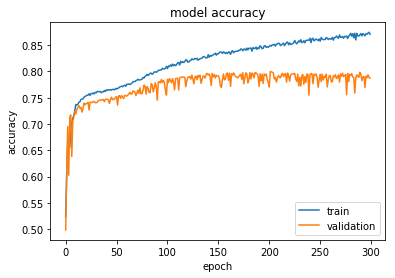

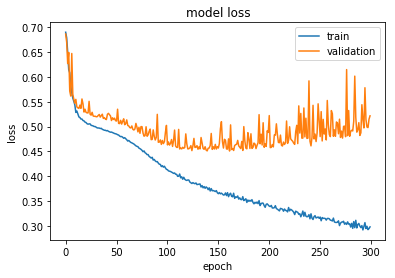

In [222]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [223]:
model.load_weights('weights//' + name + '//weights-improvement-281-0.81.hdf5')

ValueError: You are trying to load a weight file containing 4 layers into a model with 3 layers.

In [147]:
# utility function for showing images
def show_imgs_mri(x_test, pred_label, true_label, n=4, rotate=False):
    plt.figure(figsize=(20, 12))
    num_img = x_test.shape[0]
    num_rows = 1 + num_img//n
    ix = 1
    for i in range(num_img):
        ax = plt.subplot(num_rows, n, ix)
        if rotate == True:
            temp = x_test[i].reshape(x_test.shape[1::])
            temp = np.rot90(temp)
            plt.imshow(temp)
        else:
            plt.imshow(x_test[i].reshape(x_test.shape[1::]))
        plt.title('Predicted: ' + str(pred_label[ix-1]) + '   True: ' + str(true_label[ix-1]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if ix == num_img: break
        ix += 1

    plt.show()

In [172]:
from copy import deepcopy

ixs = [np.random.randint(0, len(X_validation)) for i in range(4)]
print('Indices: ', ixs)

valid_data = deepcopy(X_validation[ixs, :, :])
labels = deepcopy(Y_validation[ixs])
print(labels.T)

Indices:  [2094, 2464, 159, 4199]
[[0 0 0 1]]


In [173]:
temp = deepcopy(valid_data)
temp = np.abs(temp).astype('float32')
temp = temp/np.max(temp)
temp = temp.reshape(temp.shape + (1,))

print(temp.shape)

(4, 4, 128, 1)


In [174]:
predicted = model.predict_classes(temp)
print('Predicted: ', predicted)
print('Labels:   ', labels.T)

4/4 [==============================] - 0s 812us/step
Predicted:  [0 0 0 1]
Labels:    [[0 0 0 1]]


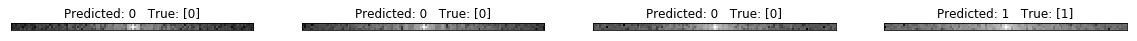

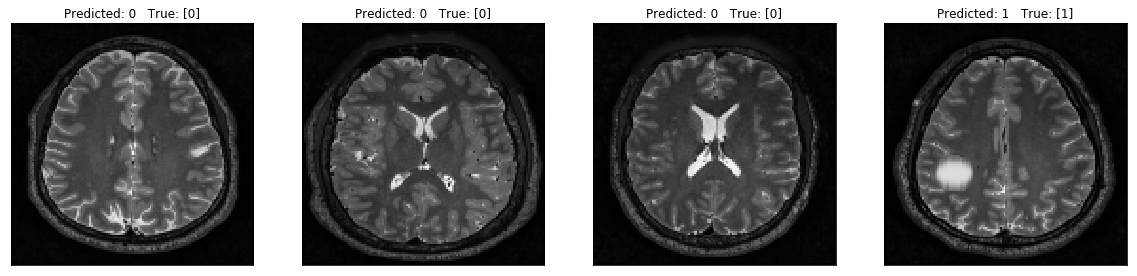

In [175]:
show_imgs_mri(np.log(np.abs(valid_data)), predicted, labels, n=4)
show_imgs_mri(np.abs(X_validation_images[ixs]), predicted, labels, n=4, rotate = True)

In [176]:
score = model.evaluate(x_train, y_train_binary, batch_size=128)
score

14670/14670 [==============================] - 0s 26us/step


[0.19988098783848962, 0.9224948873955454]

In [177]:
x_test = np.abs(X_test).astype('float32')

x_test = x_test/np.max(x_test)

x_test = x_test.reshape(x_test.shape + (1,))

print('Testing set: ', x_test.shape)

Testing set:  (4710, 4, 128, 1)


In [178]:
# Convert class vectors to binary class matrices. This uses 1 hot encoding.
num_classes = 2
y_test_binary = keras.utils.to_categorical(Y_test, num_classes)

In [179]:
score = model.evaluate(x_valid, y_valid_binary, batch_size=128)

4590/4590 [==============================] - 0s 26us/step


In [180]:
score

[0.22045456515158443, 0.9126361654215129]

In [181]:
score = model.evaluate(x_test, y_test_binary, batch_size=128)

4710/4710 [==============================] - 0s 25us/step


In [182]:
score

[0.22060617008533195, 0.9165605096553794]

4590/4590 [==============================] - 0s 21us/step
[[88.87056884 11.12943116]
 [ 6.05360444 93.94639556]]


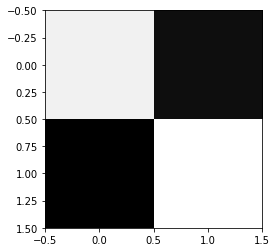

In [183]:
from sklearn.metrics import confusion_matrix

y_hat = model.predict_classes(x_valid, batch_size=128)

conf = confusion_matrix(Y_validation, y_hat)
conf = (conf*100/np.sum(conf, axis=0)).T

print(conf)
plt.imshow(conf)
plt.show()

4710/4710 [==============================] - 0s 26us/step
[[88.89334403 11.10665597]
 [ 5.23465704 94.76534296]]


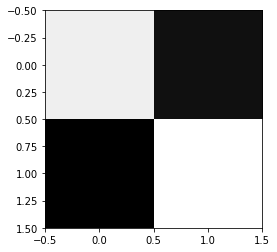

In [184]:
y_hat = model.predict_classes(x_test, batch_size=128)

conf = confusion_matrix(Y_test, y_hat)
conf = (conf*100/np.sum(conf, axis=0)).T

print(conf)
plt.imshow(conf)
plt.show()

In [144]:
err_ixs = [[]]

pred = model.predict_classes(x_test)

for ix, i in enumerate(zip(pred, Y_test)):
    if i[0] != i[1][0]:
        err_ixs[0].append(ix)

4710/4710 [==============================] - 0s 54us/step


[[3825, 1414, 1711, 279]]


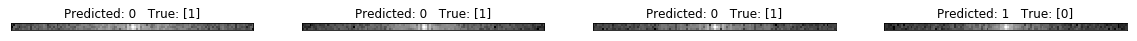

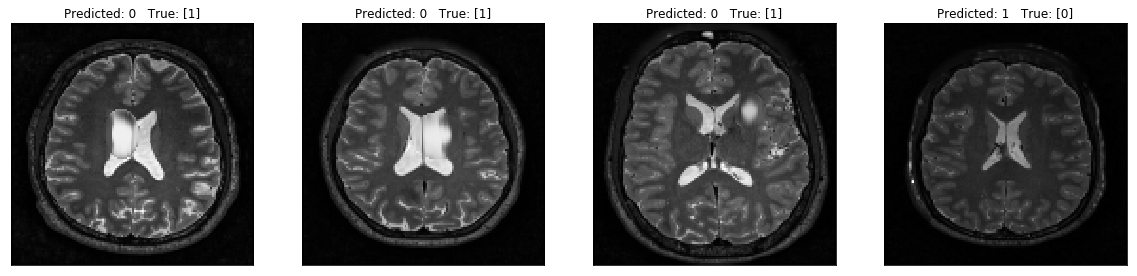

In [186]:
ixs = [list(np.random.permutation(err_ixs[0]))[0:4]]
print(ixs)

show_imgs_mri(np.log(np.abs(X_test[ixs])), pred[ixs], Y_test[ixs], n=4)
show_imgs_mri(np.abs(X_test_images[ixs]), pred[ixs], Y_test[ixs], n=4, rotate=True)

In [90]:
pred = model.predict_classes(x_test)

4890/4890 [==============================] - 2s 366us/step


In [91]:
pred

array([0, 0, 0, ..., 1, 0, 1])

<class 'numpy.complex128'>


/home/bisp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


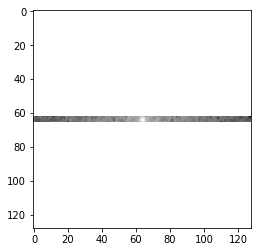

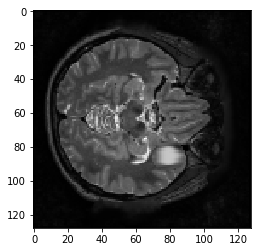

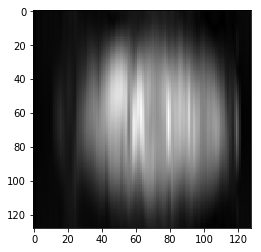

In [80]:
temp = np.zeros((128, 128), dtype=complex)

ix = 150
temp[62:66,:] = X_test[ix][2:6]

print(type(temp[0,0]))

plt.imshow(np.log(np.abs(temp)))
plt.show()

plt.imshow(np.abs(X_test_images[ix]))
plt.show()

transf = np.fft.fft2(temp)

plt.imshow(np.abs(transf))
plt.show()

In [61]:
np.max(np.abs(X_test[ix]))

582874.0447501275

In [62]:
np.min(np.abs(X_test[ix]))

8.66048980053634

In [66]:
np.max(np.abs(temp))

582874.0447501275